<a href="https://colab.research.google.com/github/Falconwatch/Hometasks/blob/main/LLM/HomeTask_LLM_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Чтение исходных данных

In [1]:
!pip install --upgrade --quiet transformers==4.36.0 \
             accelerate==0.22.0 \
             einops==0.6.1 \
             langchain==0.0.300 \
             xformers==0.0.21 \
             bitsandbytes==0.41.1 \
             sentence_transformers==2.2.2 \
             faiss-gpu==1.7.2 \
             tiktoken==0.6.0 \
             sacrebleu==2.4.0 \
             rouge==1.0.1

In [2]:
import torch
from torch import cuda, bfloat16

import transformers
from transformers import AutoTokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM
from time import time

from langchain.llms import HuggingFacePipeline
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.text_splitter import TokenTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain.chains.question_answering import load_qa_chain
from langchain.vectorstores import FAISS
from langchain.indexes import VectorstoreIndexCreator
from langchain.indexes.vectorstore import VectorStoreIndexWrapper

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rouge import Rouge
from sacrebleu.metrics import BLEU

import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [3]:
df = pd.read_excel('Выгрузка контрактов по Заказчику.xlsx')
df.head()

,ID СПГЗ,Наименование СПГЗ,Реестровый номер в РК,Номер лота в закупке,ИКЗ,Заказчик,Наименование (предмет) ГК,Способ определения поставщика,Основание заключения контракта с ед. поставщиком,Статус контракта,...,Дата регистрации,Дата последнего изменения,Срок исполнения с,Срок исполнения по,Дата окончания срока действия,Принадлежность поставщика к МСП на момент заключения ГК,Наименование субъекта РФ поставщика,Закон-основание (44/223),Электронное исполнение,Исполнено поставщиком
0,30173402.0,Услуги частной охраны (Выставление поста охраны),2837627,1.0,NaN,Закачик 1,Оказание услуг по охране помещений по адресу: ...,NaN,NaN,Исполнен,...,09.09.2019,11.11.2019,09.09.2019,19.11.2019,31.12.2019,Да,NaN,44.0,Нет,217500.00
1,40196525.0,Услуги частной охраны (Выставление поста охраны),5019693,1.0,212770135608677030100100070000000244,Закачик 1,"Оказание услуг по охране помещений, арендуемых...",закупка у единственного поставщика,4. Осуществление закупки малого объема,Исполнен,...,30.12.2021,14.04.2022,01.02.2022,01.04.2022,27.05.2022,Да,NaN,44.0,Нет,453743.04
2,40196525.0,Услуги частной охраны (Выставление поста охраны),4872211,1.0,212770135608677030100100070000000244,Закачик 1,"Оказание услуг по охране помещений, арендуемых...",закупка у единственного поставщика,4. Осуществление закупки малого объема,Исполнен,...,19.11.2021,25.01.2022,01.12.2021,31.12.2021,28.02.2022,Да,NaN,44.0,Нет,119040.00
3,16507293.0,Адаптационное сопровождение информационных сис...,3967298,1.0,NaN,Закачик 1,Оказание услуг по обеспечению функционирования...,электронный конкурс,NaN,Исполнен,...,16.12.2020,31.10.2022,12.12.2020,01.09.2022,31.10.2022,Нет,NaN,44.0,Нет,99099999.99
4,16507293.0,Адаптационное сопровождение информационных сис...,3622891,1.0,NaN,Закачик 1,Оказание комплексных услуг по технической подд...,электронный конкурс,NaN,Исполнен,...,12.08.2020,01.07.2022,11.08.2020,09.04.2022,30.06.2022,Нет,Красногорск,44.0,Нет,19265482.27


In [4]:
def generate_docs(df):
  df = df.replace({ np.NaN : 'неизвестно',
                    '\n' : ' ',
                    '\xa0' : '' }, regex=True)
  splits = []
  for i in range(len(df)):
    sp = ''
    for j in range(len(df.columns)):
      #splits.append(f'{df.iloc[i, 0]}: {df.columns[j]}? {df.iloc[i, j]}')
      sp += f'{df.iloc[i, 0]}: {df.columns[j]}? {df.iloc[i, j]}'
    splits.append(sp)

  text_splitter = TokenTextSplitter(chunk_overlap=0)
  docs = text_splitter.create_documents(splits)
  return docs

def create_vectorstore(docs, model_name):
  hf = HuggingFaceEmbeddings(
      model_name=model_name,
      model_kwargs={'device': 'cpu'},
      encode_kwargs={'normalize_embeddings': False}
  )
  vectorstore_faiss = FAISS.from_documents(
      docs,
      hf,
  )
  return vectorstore_faiss

In [5]:
docs = generate_docs(df)
docs[:5]

[Document(page_content='30173402.0: ID СПГЗ? 30173402.030173402.0: Наименование СПГЗ?  Услуги частной охраны (Выставление поста охраны)30173402.0: Реестровый номер в РК? 283762730173402.0: Номер лота в закупке? 1.030173402.0: ИКЗ? неизвестно30173402.0: Заказчик? Закачик 130173402.0: Наименование (предмет) ГК? Оказание услуг по охране помещений по адресу: г.Москва, ул. 1-я Бородинская,  дом 2А, в период с 09.09.2019 по 31.10.201930173402.0: Способ определения поставщика? неизвестно30173402.0: Основание заключения контракта с ед.  поставщиком? неизвестно30173402.0: Статус контракта? Исполнен30173402.0: № версии? 1.030173402.0: Цена ГК, руб.? 217500.030173402.0: Цена ГК при заключении, руб.? неизвестно30173402.0: Оплачено, руб.? 217500.030173402.0: Оплачено, %? 100.030173402.0: Конечный код КПГЗ? 03.10.01.0130173402.0: Конечное наименование КПГЗ? УСЛУГИ ЧАСТНОЙ ОХРАНЫ (ВЫСТАВЛЕНИЕ ПОСТА ОХРАНЫ)30173402.0: Дата заключения? 06.09.201930173402.0: Дата регистрации? 09.09.201930173402.0: Дата 

#Подготовка токенайзера и модели



In [6]:
#!huggingface-cli login

In [7]:
def prepare_tokenizer_and_model(model_id):

  device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

  bnb_config = transformers.BitsAndBytesConfig(
      load_in_4bit=True,
      bnb_4bit_quant_type='nf4',
      bnb_4bit_use_double_quant=True,
      bnb_4bit_compute_dtype=bfloat16
  )
  model_config = transformers.AutoConfig.from_pretrained(
    model_id,
    temperature=0.6
  )

  model = transformers.AutoModelForCausalLM.from_pretrained(
      model_id,
      trust_remote_code=True,
      config=model_config,
      quantization_config=bnb_config,
      device_map='auto',
  )
  tokenizer = AutoTokenizer.from_pretrained(model_id)
  return tokenizer, model

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("microsoft/Phi-3-mini-4k-instruct", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: 

model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
transformers.__version__

# Основной код (RAG)

In [ ]:
def augment_prompt(original_query, ranged_docs, model, tokenizer):
  messages = f"""
    Вы работаете в госкорпорации и отвечаете за поставки и выдачу товаров.
    Ответьте на вопрос начальтва {original_query}, основываясь только на информации из документа {ranged_docs}.
    Дайте ответ на русском языке. Отвечайте четко на поставленный вопрос. В случае успешного ответа вы получите 200000$"
  """
  pipe = transformers.pipeline(
      "text-generation",
      model=model,
      tokenizer=tokenizer,
      torch_dtype=torch.float16,
      device_map="auto")

  llm = HuggingFacePipeline(pipeline=pipe)
  content= llm(prompt=messages)
  return content

In [ ]:
def rag(query, vectorstore_faiss, model, tokenizer):
  query_embedding = vectorstore_faiss.embedding_function(query)
  relevant_documents = vectorstore_faiss.similarity_search_by_vector(query_embedding, 8)
  print(f'Было найдено {len(relevant_documents)} документов, похожих на запрос пользователей.')
  print('----')

  info = []
  for i, rel_doc in enumerate(relevant_documents):
      print(f'## Document {i+1}: {rel_doc.page_content}.......')
      info.append(rel_doc.page_content)

  info = ''.join(info)
  return augment_prompt(query, info, model, tokenizer)

# Тестирование 😊

In [ ]:
def rouge (hypothesis, reference):
  rouge_scorer = Rouge()
  score = rouge_scorer.get_scores(
      hyps=hypothesis,
      refs=reference,
  )
  return score[0]["rouge-l"]["f"]

def bleu (hypothesis, reference):
  bleu_scorer = BLEU(effective_order=True)
  score = bleu_scorer.sentence_score(
      hypothesis=hypothesis,
      references=[reference],
  )
  return score.score / 100

In [ ]:
queries = [ "Расскажи об услуге с реестровым номером 2837627",
            "Какие способы определения поставщика ты знаешь?",
            "Какие услуги были оказаны за последний месяц?",
            "Какое конечное наименование КПГЗ?"
          ]

human_answers = []

#bleu_metrics, rouge_metrics = [[] for i in range(6)], [[] for i in range(6)]

In [ ]:
def get_response(query_num, vectorstore, model, tokenizer):
  print(f'Запрос пользователя: {queries[query_num]}')
  resp = rag(query=queries[query_num],
                    vectorstore_faiss=vectorstore,
                    model=model,
                    tokenizer=tokenizer)
  print(f'Ответ: {resp}')

  #bleu_metrics[query_num].append(bleu(human_answers[query_num], resp))
  #rouge_metrics[query_num].append(rouge (human_answers[query_num], resp))

**Модель sentence_transformers: all-mpnet-base-v2**

In [ ]:
model_name = "sentence-transformers/all-mpnet-base-v2"
vectorstore = create_vectorstore(docs, model_name)

In [ ]:
get_response(0, vectorstore, model, tokenizer)

In [ ]:
get_response(1, vectorstore, model, tokenizer)

In [ ]:
get_response(2, vectorstore, model, tokenizer)

In [ ]:
get_response(3, vectorstore, model, tokenizer)

**Модель sentence_transformers: all-distilroberta-v1**

In [ ]:
model_name = "sentence-transformers/all-distilroberta-v1"
vectorstore = create_vectorstore(docs, model_name)

.gitattributes:   0%|          | 0.00/737 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
get_response(0, vectorstore, model, tokenizer)

Запрос пользователя: Какие госпрограммы ты знаешь?
Было найдено 8 документов, похожих на запрос пользователей.
----
## Document 1: Кавказ.РФ: 
Название Программа? Кавказ.РФ.......
## Document 2: Кавказ.РФ: Вывод в Конструктор? нет.......
## Document 3: Кавказ.РФ: Цель кредита? неизвестно.......
## Document 4: Кавказ.РФ: Статус? неизвестно.......
## Document 5: МЭР.Туризм ПП 141 (Постановление  от 09.02.2021 №141 ): Ограничение по виду деятельности заемщика? нет ограничений.......
## Document 6: Кавказ.РФ: Требования к заемщику (получателю субсидии)? неизвестно.......
## Document 7: Кавказ.РФ: Ограничение по виду деятельности заемщика? есть ограничения - проверка по ОКВЭД.......
## Document 8: Кавказ.РФ: Префикс с системах банка? неизвестно.......
Ответ: 
Вот ответ на вопрос пользователя:

"Конечно! Я могу помочь вам с ответом на ваш вопрос.

В соответствии с информацией, предоставленной в тексте, я могу сказать, что госпрограммы, которые я знаю, - это:

* МЭР.Туризм ПП 141 (Постановлен

In [ ]:
get_response(1, vectorstore, model, tokenizer)

Запрос пользователя: доступно ли получение кредита на проект в крыму по технологии кредит за 7 минут?
Было найдено 8 документов, похожих на запрос пользователей.
----
## Document 1: Кавказ.РФ: Доступен в Кредит за 7 мин (К7М)? неизвестно.......
## Document 2: Кавказ.РФ: Сроки кредитования? Для оборотного кредитования - до 1 года. Для инвестиционного кредитования - до 5 лет........
## Document 3: МЭР.Туризм ПП 141 (Постановление  от 09.02.2021 №141 ): Доступен в Кредит за 7 мин (К7М)? нет.......
## Document 4: Проекты в Крыму и Севастополе ПП 2221 от 07.12.2021: Доступен в Кредит за 7 мин (К7М)? нет.......
## Document 5: МЭР 1764_МСП (Постановление от 30.12.2018 №1764): Доступен в Кредит за 7 мин (К7М)? да.......
## Document 6: МЭР.Туризм ПП 141 (Постановление  от 09.02.2021 №141 ): Вид кредита? Инвестиционный кредит.......
## Document 7: МЭР 1764_МСП (Постановление от 30.12.2018 №1764): Сроки кредитования? Сроки кредитования: оборотка – до 3 лет (период субсидирования до 1 года) инвест

In [ ]:
get_response(2, vectorstore, model, tokenizer)

Запрос пользователя: Какая ставка по программе Туризм?
Было найдено 8 документов, похожих на запрос пользователей.
----
## Document 1: Кавказ.РФ: 
Название Программа? Кавказ.РФ.......
## Document 2: Кавказ.РФ: Ограничение по виду деятельности заемщика? есть ограничения - проверка по ОКВЭД.......
## Document 3: Кавказ.РФ: Процентая ставка? Льготная ставка - не более 9,5%.......
## Document 4: Кавказ.РФ: Требования к заемщику (получателю субсидии)? неизвестно.......
## Document 5: Кавказ.РФ: Префикс с системах банка? неизвестно.......
## Document 6: Кавказ.РФ: Цель кредита? неизвестно.......
## Document 7: Кавказ.РФ: Вывод в Конструктор? нет.......
## Document 8: Кавказ.РФ: Наличие лимита на Банк? есть.......
Ответ: 
"Какая ставка по программе Туризм?"

В соответствии с информацией из приведенного текста, стараясь ответить на вопрос пользователя как точно и точно, ответ будет следующим:

"Ставка по программе Туризм может быть не более 9,5%."

Таким образом, по программе Туризм заемщики м

In [ ]:
get_response(3, vectorstore, model, tokenizer)

Запрос пользователя: Кто куратор в банке программы Туризм?
Было найдено 8 документов, похожих на запрос пользователей.
----
## Document 1: Кавказ.РФ: 
Название Программа? Кавказ.РФ.......
## Document 2: Кавказ.РФ: Вывод в Конструктор? нет.......
## Document 3: Кавказ.РФ: Цель кредита? неизвестно.......
## Document 4: Кавказ.РФ: Ограничение по виду деятельности заемщика? есть ограничения - проверка по ОКВЭД.......
## Document 5: МЭР.Туризм ПП 141 (Постановление  от 09.02.2021 №141 ): Ограничение по виду деятельности заемщика? нет ограничений.......
## Document 6: Проекты в Крыму и Севастополе ПП 2221 от 07.12.2021: Вывод в Конструктор? нет.......
## Document 7: Проекты в Крыму и Севастополе ПП 2221 от 07.12.2021: Фондирование? субсидии Мистроя ежемесячно.......
## Document 8: МЭР.Туризм ПП 141 (Постановление  от 09.02.2021 №141 ): Вывод в Конструктор? нет.......
Ответ: 
Ваш ответ:
Кто куратор в банке программы Туризм?
Основываясь на информации из приведенного текста, можно сказать, что 

**Модель sentence_transformers: multi-qa-mpnet-base-dot-v1**

In [ ]:
model_name = "sentence-transformers/multi-qa-mpnet-base-dot-v1"
vectorstore = create_vectorstore(docs, model_name)

.gitattributes:   0%|          | 0.00/737 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.71k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.9k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [ ]:
get_response(0, vectorstore, model, tokenizer)

Запрос пользователя: Какие госпрограммы ты знаешь?
Было найдено 8 документов, похожих на запрос пользователей.
----
## Document 1: МЭР 1764_МСП (Постановление от 30.12.2018 №1764): 
Название Программа? МЭР 1764_МСП (Постановление от 30.12.2018 №1764).......
## Document 2: МЭР.Туризм ПП 141 (Постановление  от 09.02.2021 №141 ): 
Название Программа? МЭР.Туризм ПП 141 (Постановление  от 09.02.2021 №141 ).......
## Document 3: МЭР.Туризм ПП 141 (Постановление  от 09.02.2021 №141 ): Соглашение с ФОИВ? есть.......
## Document 4: МЭР 1764_МСП (Постановление от 30.12.2018 №1764): Какой ФОИВ/РОИВ является владельцем программы? МЭР.......
## Document 5: Кавказ.РФ: Ограничение по виду деятельности заемщика? есть ограничения - проверка по ОКВЭД.......
## Document 6: МЭР.Туризм ПП 141 (Постановление  от 09.02.2021 №141 ): Какой ФОИВ/РОИВ является владельцем программы? МЭР.......
## Document 7: МЭР.Туризм ПП 141 (Постановление  от 09.02.2021 №141 ): Должен ли принадлежать  заемщик к субъекту МСП? не

In [ ]:
get_response(1, vectorstore, model, tokenizer)

Запрос пользователя: доступно ли получение кредита на проект в крыму по технологии кредит за 7 минут?
Было найдено 8 документов, похожих на запрос пользователей.
----
## Document 1: Проекты в Крыму и Севастополе ПП 2221 от 07.12.2021: Доступен в Кредит за 7 мин (К7М)? нет.......
## Document 2: МЭР.Туризм ПП 141 (Постановление  от 09.02.2021 №141 ): Доступен в Кредит за 7 мин (К7М)? нет.......
## Document 3: Кавказ.РФ: Сроки кредитования? Для оборотного кредитования - до 1 года. Для инвестиционного кредитования - до 5 лет........
## Document 4: МЭР.Туризм ПП 141 (Постановление  от 09.02.2021 №141 ): Вид кредита? Инвестиционный кредит.......
## Document 5: МЭР.Туризм ПП 141 (Постановление  от 09.02.2021 №141 ): Сроки кредитования? Срок - до 15 лет.......
## Document 6: Проекты в Крыму и Севастополе ПП 2221 от 07.12.2021: Сроки кредитования? Срок кредита - не более 10 лет Срок льготного кредитования - до конца 2027.......
## Document 7: КОМБО (ПСК+ МЭР 1764): Сроки кредитования? Срок - до

In [ ]:
get_response(2, vectorstore, model, tokenizer)

Запрос пользователя: Какая ставка по программе Туризм?
Было найдено 8 документов, похожих на запрос пользователей.
----
## Document 1: МЭР.Туризм ПП 141 (Постановление  от 09.02.2021 №141 ): 
Название Программа? МЭР.Туризм ПП 141 (Постановление  от 09.02.2021 №141 ).......
## Document 2: МЭР.Туризм ПП 141 (Постановление  от 09.02.2021 №141 ): Максимальная сумма кредита? неизвестно.......
## Document 3: Проекты в Крыму и Севастополе ПП 2221 от 07.12.2021: 
Название Программа? Проекты в Крыму и Севастополе ПП 2221 от 07.12.2021.......
## Document 4: МЭР 1764_МСП (Постановление от 30.12.2018 №1764): 
Название Программа? МЭР 1764_МСП (Постановление от 30.12.2018 №1764).......
## Document 5: Кавказ.РФ: Ограничение по виду деятельности заемщика? есть ограничения - проверка по ОКВЭД.......
## Document 6: Кавказ.РФ: 
Название Программа? Кавказ.РФ.......
## Document 7: Проекты в Крыму и Севастополе ПП 2221 от 07.12.2021: Процентая ставка? Льготная процентная ставка устанавливается в размере раз

In [ ]:
get_response(3, vectorstore, model, tokenizer)

Запрос пользователя: Кто куратор в банке программы Туризм?
Было найдено 8 документов, похожих на запрос пользователей.
----
## Document 1: МЭР.Туризм ПП 141 (Постановление  от 09.02.2021 №141 ): Вывод в Конструктор? нет.......
## Document 2: Кавказ.РФ: Кураторы программы в банке? ККСБ, Госсектор, ММБ, КСБ - М. Елена, ДКПП -С.  Виктория.......
## Document 3: МЭР.Туризм ПП 141 (Постановление  от 09.02.2021 №141 ): Максимальная сумма кредита? неизвестно.......
## Document 4: МЭР.Туризм ПП 141 (Постановление  от 09.02.2021 №141 ): Кураторы программы в банке? УФН - Я. Мария, ДРКБ - М. Елена, GR - Б. Татьяна.......
## Document 5: КОМБО (ПСК+ МЭР 1764): Кураторы программы в банке? КСБ - М. Елена, ДКПП -С. Виктория, GR - П. Мария.......
## Document 6: Проекты в Крыму и Севастополе ПП 2221 от 07.12.2021: 
Название Программа? Проекты в Крыму и Севастополе ПП 2221 от 07.12.2021.......
## Document 7: МЭР.Туризм ПП 141 (Постановление  от 09.02.2021 №141 ): 
Название Программа? МЭР.Туризм ПП 141 (По

# Анализ полученных результатов

In [ ]:
def draw_barplot(metric_scores, metric_name):
  barWidth = 0.15
  fig = plt.subplots(figsize =(12, 8))

  br1 = np.arange(len(metric_scores[0]))
  br2 = [x + barWidth for x in br1]
  br3 = [x + barWidth for x in br2]
  br4 = [x + barWidth for x in br3]
  br5 = [x + barWidth for x in br4]
  br6 = [x + barWidth for x in br5]

  bar1 = plt.bar(br1, metric_scores[0], color ='#FFBF00', width = barWidth,
          edgecolor ='grey', label ='prompt #1')
  bar2 = plt.bar(br2, metric_scores[1], color ='#FF7F50', width = barWidth,
          edgecolor ='grey', label ='prompt #2')
  bar3 = plt.bar(br3, metric_scores[2], color ='#DE3163', width = barWidth,
          edgecolor ='grey', label ='prompt #3')
  bar4 = plt.bar(br4, metric_scores[3], color ='#40E0D0', width = barWidth,
          edgecolor ='grey', label ='prompt #4')
  bar5 = plt.bar(br5, metric_scores[4], color ='#FA8072', width = barWidth,
          edgecolor ='grey', label ='prompt #5')
  bar6 = plt.bar(br6, metric_scores[5], color ='#DFFF00', width = barWidth,
          edgecolor ='grey', label ='prompt #6')

  for rect in bar1 + bar2 + bar3 + bar4 + bar5 + bar6:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:{0:0.3f}}', ha='center', va='bottom')


  plt.xlabel('Sentence transformers', fontweight ='bold', fontsize = 15)
  plt.ylabel('Metric scores', fontweight ='bold', fontsize = 15)
  plt.xticks([r + barWidth for r in range(len(metric_scores[0]))],
          ['all-mpnet-base-v2', 'all-distilroberta-v1', 'multi-qa-mpnet-base-dot-v1'])
  plt.title(metric_name, fontweight ='bold', fontsize = 17)
  plt.legend()

  plt.savefig(metric_name + ".pdf", format="pdf", bbox_inches="tight")
  plt.show()

In [ ]:
bleu_metrics, rouge_metrics

([[0.26766952647116987, 0.8882650520322768, 0.25322091927921675],
  [0.1690660843876625, 0.05264772373293555, 0.1536109570615018],
  [0.005285251283368021, 0.010570502566736042, 0.1042790710277],
  [0.06697054787621348, 0.027674590787661678, 0.0699454190330146],
  [0.1720532310112605, 0.12863979464893072, 0.3401410824602234],
  [0.6288734231154859, 0.27522472229908923, 0.5448903486075027]],
 [[0.48351647895664784, 0.2499999955555556, 0.271844655911019],
  [0.21428571020408166, 0.18556700658518446, 0.31578946990803325],
  [0.6779660713588064, 0.7272726952727286, 0.8130081137946993],
  [0.15384614958579892, 0.8450703876215051, 0.1290322542351718],
  [0.7692307233124047, 0.8433734523660928, 0.6956521691493385],
  [0.3884892037472181, 0.21212120717745647, 0.21176470163598624]])

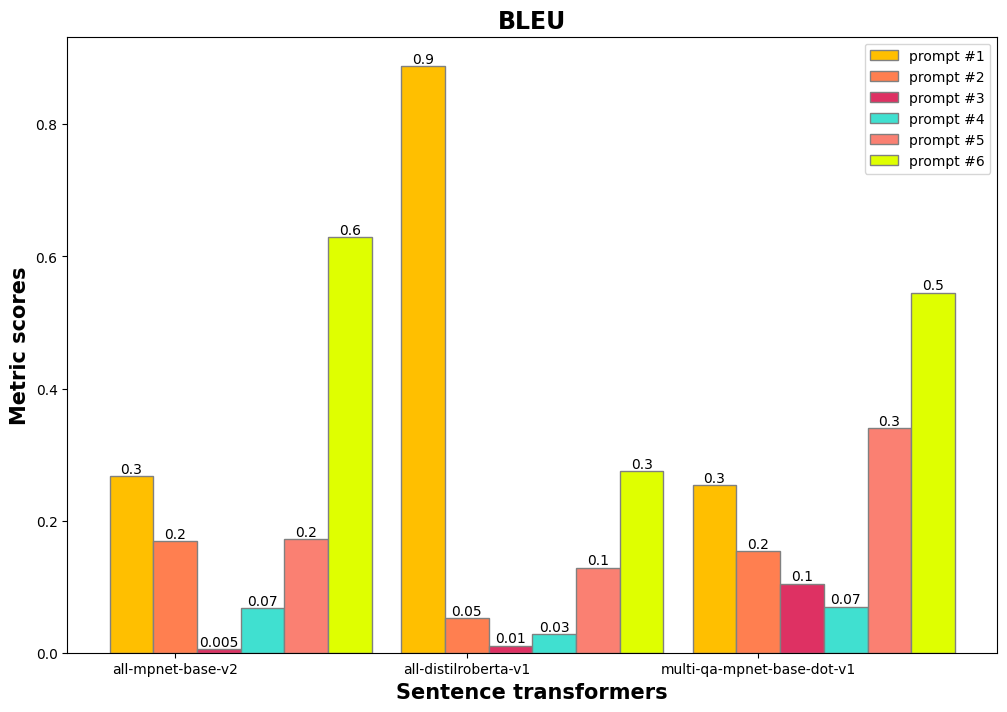

In [ ]:
draw_barplot(bleu_metrics, "BLEU")

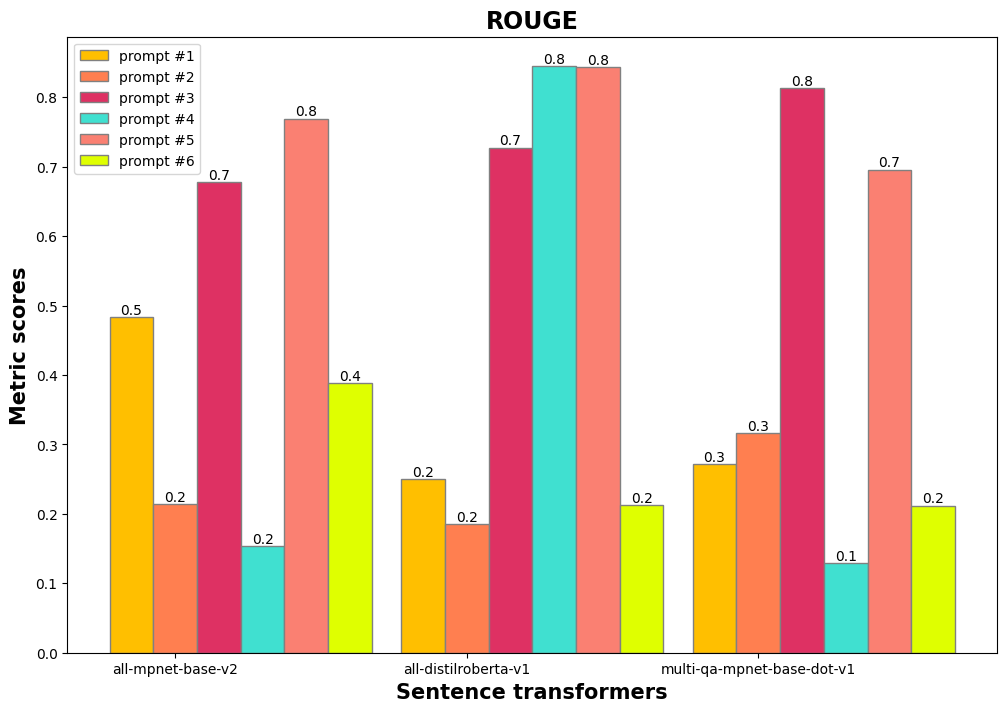

<Figure size 640x480 with 0 Axes>

In [ ]:
draw_barplot(rouge_metrics, "ROUGE")